# Simulation Run Log Analysis and Visualization for AWS DeepRacer

This notebook walks through how you can analyze and debug using the AWS DeepRacer Simulation logs 

```
1. Tools to find best iteration of your model
2. Visualize reward distribution on the track
  2.1 Visualize reward heatmap per episode or iteration
3. Identify hotspots on the track for your model
4. Understand probability distributions on simulated images
5. Evaluation run analysis - plot lap speed heatmap
```

## Requirements

boto3 >= 1.9.133  ; configure your aws cli and/or boto credentials file

AWS CLI: https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-configure.html

Boto Configuration: https://boto3.amazonaws.com/v1/documentation/api/latest/guide/configuration.html

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

#Shapely Library
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString

import track_utils as tu
import log_analysis as la
import cw_utils as cw

# Make sure your boto version is >= '1.9.133'
cw.boto3.__version__

'1.9.210'

In [2]:
# reload log_analysis and the rest of stuff here if needed
# (handy for code updates in utils, doesn't break anything if no changes)
import importlib
importlib.reload(la)
importlib.reload(cw)
importlib.reload(tu)

<module 'track_utils' from '/home/ccsantos/deepracer-for-dummies/aws-deepracer-workshops/log-analysis/track_utils.py'>

## Load waypoints for the track you want to run analysis on

Tracks Available:

In [3]:
!ls tracks/

AWS_track.npy	  London_Loop_Train.npy    reinvent_base.npy
Bowtie_track.npy  New_York_Eval_Track.npy  Straight_track.npy
China_track.npy   New_York_Track.npy	   Tokyo_Training_track.npy
H_track.npy	  Oval_track.npy	   Virtual_May19_Train_track.npy


Loaded 71 waypoints


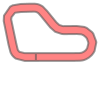

In [4]:
l_center_line, l_inner_border, l_outer_border, road_poly = tu.load_track("reinvent_base")

road_poly

## Load all evaluation data

It's good to keep things organised: group your files into folders to not lose track where they came from.

In [5]:
#print log files and show most recent. You may want to use that file for analysis
import os
file_list = []
for file in os.listdir("logs"):
    if(file=="latest"):
        continue
    file_list.append([os.stat(os.path.join("logs", file)).st_mtime, os.path.join("logs", file)])
    file_list.sort(key=lambda x: x[0])  # sort by creation date
    print(file + "   :   " + str(os.stat(os.path.join("logs", file)).st_mtime))
print("\nMost recent file  = " + file_list[-1][1])
fname = file_list[-1][1]

deepracer-fe179db0-c1f3-11e9-8c5c-0242ac120004.log   :   1566166485.1706324
c02f1706-c13c-11e9-8ad0-0242ac120004   :   1566080238.9316764
deepracer-5bf07a28-c1ff-11e9-ae47-0242ac120004.log   :   1566166072.0296586
deepracer-sim-ghy8fskj27j4.log   :   1566869693.3460143
deepracer-Oval_track.log   :   1566167056.440198
deepracer-Oval_Track.log   :   1566178685.2514682
log   :   1566872798.891943
deepracer-eval-sim-j5gdq7sxh2c2.log   :   1566872764.1999426
deepracer-sim-2zfqgg08b2bl.log   :   1566260306.61707
deepracer-sim-sample.log   :   1566167020.652166
deepracer-dr-sm-rltj--20190819134949-f350b748-9893-4350-8d32-3869ab5038e3.log   :   1566261861.6997128
deepracer-6ebf6bca-c13f-11e9-bd3a-0242ac120004.log   :   1566166471.5945964
deepracer-sim-j5gdq7sxh2c2.log   :   1566261926.8624902

Most recent file  = logs/log


### Download the desired log file given the simulation ID 


If you wish to bulk export the logs from Amazon Cloudwatch to Amazon S3 :: 
https://docs.aws.amazon.com/AmazonCloudWatch/latest/logs/S3ExportTasks.html

_Use `force=True` to download again_

In [8]:
AWS_train_ID = 'sim-ghy8fskj27j4'
stream_name = AWS_train_ID ## CHANGE This to your simulation application ID
fname = 'logs/deepracer-%s.log' %stream_name
cw.download_log(fname, stream_prefix=stream_name)

!tail -n 3 $fname

Log file exists, use force=True to download again
SIM_TRACE_LOG:19,213,5.3787,1.0963,0.4406,0.52,0.50,8,0.0010,False,False,18.9704,8,17.67,1566861623.0788045
SIM_TRACE_LOG:19,214,5.3894,1.1003,0.4347,0.00,0.50,4,0.0000,True,False,19.0314,8,17.67,1566861623.1478322
Training> Name=main_level/agent, Worker=0, Episode=20, Total reward=217.23, Steps=2133, Training iteration=0


## Load the trace training log

In [9]:
EPISODES_PER_ITERATION = 20 #  Set to value of your hyperparameter in training

data = la.load_data(fname)
#df = la.convert_to_pandas(data, episodes_per_iteration=EPISODES_PER_ITERATION)
df = la.convert_to_pandas(data)

df = df.sort_values(['episode', 'steps'])
# personally I think normalizing can mask too high rewards so I am commenting it out,
# but you might want it.
# la.normalize_rewards(df)

Note the first line below: it takes a reward class from log-analysis/rewards, imports, instantiates and recalculates for the log. This lets you do some testing before you start training and rule out some obvious things.

Just remember: not all params are provided, you are free to implement them and raise a Pull Request for log_analysis.df_to_params method.

Wrap your reward function like in the sample one below.

Final warning: there is a loss of precision in the logs and also potentially potential bugs. If you find any, please fix, please report.

In [10]:
la.new_reward(df, l_center_line, 'reward.reward_sample') #, verbose=True)

simulation_agg = la.simulation_agg(df)

la.analyze_training_progress(simulation_agg, title='Training progress')

# This gives the warning about ptp method deprecation. The code looks as if np.ptp was used, I don't know how to fix it.
la.scatter_aggregates(simulation_agg, 'Stats for all laps')

complete_ones = simulation_agg[simulation_agg['progress']==100]

if complete_ones.shape[0] > 0:
    la.scatter_aggregates(complete_ones, 'Stats for complete laps')

la.analyze_categories(simulation_agg, title='Quintiles')

AttributeError: module 'log_analysis' has no attribute 'new_reward'

The calls below are useful when you want to look at some values largest or smallest. You can then take the episode number and scatter it below.

In [ ]:
# this is useful if you struggle to get a complete lap
simulation_agg.nlargest(10, 'new_reward')

In [ ]:
# fastest complete laps
complete_ones.nsmallest(5, 'time')

In [ ]:
# best rewards in completed laps
complete_ones.nlargest(5, 'reward')

In [ ]:
# best rewards in completed laps
complete_ones.nlargest(5, 'new_reward')

In [ ]:
# this is useful if you struggle to get a complete lap
simulation_agg.nlargest(5, 'progress')

In [ ]:
# list all entries aggregated per episode. Handy for comparing the outcomes for reward and new_reward,
# but for not much else.
simulation_agg.head()

In [ ]:
pd.set_option('display.max_rows', 500)

# list all parsed log lines. Handy for comparing the outcomes for reward and new_reward,
# but for not much else.
df[df['episode']==10]

In [ ]:
#This shows a histogram of actions per waypoint. Will let you spot potentially problematic places
episode = df[df['episode']==771]
episode[:-1].plot.bar(x='closest_waypoint', y='reward')

## Analyze the reward distribution for your reward function

### Path taken for top reward iterations

NOTE: in a single episode, the car can go around multiple laps, the episode is terminated when car completes 1000 steps

In [ ]:
action_map, episode_map, sorted_idx = la.episode_parser(data)    
fig = la.plot_top_laps(sorted_idx[:],  episode_map, l_center_line, l_inner_border, l_outer_border, 3)

In [ ]:
# because Kumo Torakku has negative y values, I shamelessly took
# RichardFan's modificationg for plot_track and refactored it to offer an x_shift and y_shift
# They may not apply to other tracks. You will need to change it in the future. Simply add parameters:
# track_size=(700,1000), y_shift=300
track = la.plot_track(df, l_center_line, l_inner_border, l_outer_border)

plt.title("Reward distribution for all actions ")
im = plt.imshow(track, cmap='hot', interpolation='bilinear', origin="lower") 

### Plot a particular iteration


In [ ]:
iteration_id = 3
track = la.plot_track(df[df['iteration'] == iteration_id], l_center_line, l_inner_border, l_outer_border)
plt.title("Reward distribution for all actions ")
im = plt.imshow(track, cmap='hot', interpolation='bilinear', origin="lower") 

### Path taken in a particular episode

In [ ]:
## Evaluation RUN
def plot_episode_run(df, E, center_line, inner_border, outer_border):
    fig = plt.figure(1, figsize=(12, 16))
    ax = fig.add_subplot(211)
    la.print_border(ax, center_line, inner_border, outer_border) 
    episode_data = df[df['episode'] == E]
    for row in episode_data.iterrows():
        x1,y1,action,reward = row[1]['x'], row[1]['y'], row[1]['action'], row[1]['reward']
        car_x2, car_y2 = x1 - 0.02, y1
        plt.plot([x1, car_x2], [y1, car_y2], 'r.')

In [ ]:
plot_episode_run(df, 122, l_center_line, l_inner_border, l_outer_border) # arbitrary episode

### Path taken in a particular Iteration

In [ ]:
iteration_id = 10
EPISODE_PER_ITER = 40 # TODO this can be fetched from training logs

for i in range((iteration_id-1)*EPISODE_PER_ITER, (iteration_id)*EPISODE_PER_ITER):
    plot_episode_run(df, i, l_center_line, l_inner_border, l_outer_border)

# Bulk training load

This is some slow and heavy stuff in here. You can download all logs (or part of them if you play with `not_older_than` and `older_than` parameters that take a string representation of a date in ISO format, for instance `DD-MM-YYYY` works).

Since it can be a lot of downloading, it is commented out in here.

Files downloaded once will not be downloaded again unless you add `force=True`.

In [ ]:
#logs = cw.download_all_logs('logs/SELECT_YOUR_SUBFOLDER/training/deepracer-', '/aws/robomaker/SimulationJobs')

Load every log from a folder. Every single one. This is a lot of data. If you want to save yourself some time later, below you have code to save and load all that with use of pickle.

In [ ]:
import os

base_folder = 'logs/SELECT_YOUR_SUBFOLDER/training'
df_list = list()
big_training_panda = None
for stream in os.listdir(base_folder):
    data = la.load_data('%s/%s' % (base_folder, stream))
    df = la.convert_to_pandas(data)
    df['stream'] = stream[10:]
    if big_training_panda is not None:
        big_training_panda = big_training_panda.append(df)
    else:
        big_training_panda = df


In [ ]:
# Have I mentioned a lot of data? This stores the data preprocessed for time savings
big_training_panda.to_pickle('bulk_training_set.pickle')

In [ ]:
from pandas import read_pickle

big_training_panda = read_pickle('bulk_training_set.pickle')

In [ ]:
# as usual, handle with care. Towards the end of the London Loop I needed 30-45 minutes to recalculate the reward.
#la.new_reward(big_training_panda, l_center_line, 'reward.reward_sample')

In [ ]:
big_simulation_agg = la.simulation_agg(big_training_panda, 'stream')

big_complete_ones = big_simulation_agg[big_simulation_agg['progress']==100]

In [ ]:
grouped = big_simulation_agg.groupby(['stream'])

for name, group in grouped:
    la.scatter_aggregates(group, title=name)

By the end of London Loop I had so much noise and random tries that wanted to find the most promising version of my model to submit. I used the below piece of code to iterate through all the stream values to detect the one with most promising times histogram. I should've added progress as well since the fastest ones hardly ever completed a lap. I will leave adding that as an exercise for the reader.

In [ ]:
values = []
show = []
show_above = -1
i = 0
for value in big_complete_ones.stream.values:
    if value in values:
        continue
    values.append(value)
    if i in show or i > show_above:
        print(value)
        big_complete_ones[big_complete_ones['stream']==value].hist(column=['time'], bins=20)
    i += 1

In [ ]:
# display loads of everything
big_simulation_agg

# Action breakdown per iteration and historgram for action distribution for each of the turns - reinvent track

This plot is useful to understand the actions that the model takes for any given iteration. 

This is a bit of an attempt to abstract away from the brilliant function in the original notebook towards a more general graph that we could use. It should be treated as a work in progress. The track_breakdown could be used as a starting point for a general track information object to handle all the customisations needed in methods of this notebook.

A breakdown track data needs to be available for it. If you cannot find it for the desired track, MAKEIT.

Currently supported tracks:

In [ ]:
la.track_breakdown.keys()

The second parameter is either a single index or a list of indices for df iterations that you would like to view. You can for instance use `sorted_idx` list which is a sorted list of iterations from the highest to lowest reward.

Bear in mind that you will have to provide a proper action naming in parameter `action_names`, this function assumes only six actions by default. I think they need to match numbering of actions in your model's metadata json file.

In [ ]:
la.action_breakdown(df, 20, la.track_breakdown['reinvent2018'], l_center_line, l_inner_border, l_outer_border)